In [2]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import statistics as sts
import matplotlib.pyplot as plt

from scipy.stats import spearmanr
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.linear_model import LinearRegression


np.set_printoptions(threshold=sys.maxsize, suppress=True)
pd.set_option('display.max_columns', None, 'display.max_rows', None)

sns.set_context("notebook", font_scale=1.0,
                rc={"lines.linewidth": 2.5})

In [359]:
# Six datasets based on corpus x model

#data = pd.read_csv("word2vec_wiki_norms_vectors_annos_categories.csv")

#data = pd.read_csv("word2vec_giga_norms_vectors_annos_categories.csv")

data = pd.read_csv("word2vec_ukwac_norms_vectors_annos_categories.csv")

#data = pd.read_csv("fasttext_wiki_norms_vectors_annos_categories.csv")

#data = pd.read_csv("fasttext_giga_norms_vectors_annos_categories.csv")

#data = pd.read_csv("fasttext_ukwac_norms_vectors_annos_categories.csv")

In [360]:
# Get norm and annotation values        

norms = data['norm']
annotations = data['annotation']

norms = [norm for norm in norms.values]
annotations = [anno for anno in annotations.values]

In [361]:
def map_annotations(annotations):
    
    annotations_map = {x: index for index, x in enumerate(np.unique(annotations), start=0)}
    annotation = np.asarray([annotations_map[annotation] for annotation in annotations])
    return annotation

In [362]:
# Get vectors for each category. Converts each str repr of vector to vector

vectors = data['vector']

x = [np.array(np.matrix(vector)).ravel() for vector in vectors.values]

In [363]:
# Get scores for each category

happy_scores = [score for score in data['happy_sad']]
healthy_scores = [score for score in data['healthy_unhealthy']]
cheap_scores = [score for score in data['cheap_expensive']]
environ_scores = [score for score in data['environ_friendly']]
casual_scores = [score for score in data['casual_posh']]
local_scores = [score for score in data['local_foreign']]

In [364]:
# Transform x, y to numpy arrays for each category

x, y = np.array(x), np.array(casual_scores)

In [365]:
# Build LinearRegression model instance for multilinear regression and fit

model = LinearRegression()

In [366]:
# 10 Fold Cross-Validation

predictions = []
y_test_lst = []

kf = KFold(n_splits=10)
kf.get_n_splits(x)

for k, (train_index, test_index) in enumerate(kf.split(x, y)):

    x_train, x_test, y_train, y_test = x[train_index], x[test_index], y[train_index], y[test_index]

    model.fit(x_train, y_train)

    cv_y_pred = model.predict(x_test)
    
    predictions.append(cv_y_pred)
    y_test_lst.append(y_test)

In [367]:
cv_pred = [p for pred in predictions for p in pred]
y_tests = [y for y_test in y_test_lst for y in y_test]

cv_pred, y_tests = np.array(cv_pred), np.array(y_tests)

rho, pval = spearmanr(cv_pred, y)
print('Spearman Rho:', rho, "pvalue:", pval)
print('Standard Deviation (cv_pred):', sts.stdev(cv_pred), '\n')
print('Mean (cv_pred):', cv_pred.mean())
print('Max (cv_pred):', cv_pred.max())
print('Min (cv_pred):', cv_pred.min(), '\n')

#for p in cv_pred:
#    print(p)

Spearman Rho: 0.6504677861588984 pvalue: 4.434804234766626e-25
Standard Deviation (cv_pred): 1.8388752782839088 

Mean (cv_pred): 3.6917052635296126
Max (cv_pred): 10.922276857300819
Min (cv_pred): -0.6698461082884375 



In [368]:
# Get metric for each fold in 10 Fold Cross Validation

cor_lst = list(zip(predictions, y_test_lst))
spearman_lst = []

for cv_pred, y in cor_lst:
    spearman_lst.append(spearmanr(cv_pred, y)[0])

print('Mean Folds:', np.mean(spearman_lst))
print('Max Folds:', np.max(spearman_lst))
print('Min Folds:', np.min(spearman_lst))

print('Standard Deviation Folds:', str(sts.stdev(np.array(spearman_lst))) + '\n')

for i, s in enumerate(spearman_lst):
    print(s)

Mean Folds: 0.6544129609121199
Max Folds: 0.8280701754385964
Min Folds: 0.29559987047190067
Standard Deviation Folds: 0.16519738095720563

0.524812030075188
0.8180451127819548
0.29559987047190067
0.5227529515978905
0.6694246430534136
0.7637323456234041
0.6631578947368421
0.7634928334822793
0.6950417518597302
0.8280701754385964


In [369]:
# Prepare for plotting

cv_pred = [p for pred in predictions for p in pred]

y = np.array(casual_scores)

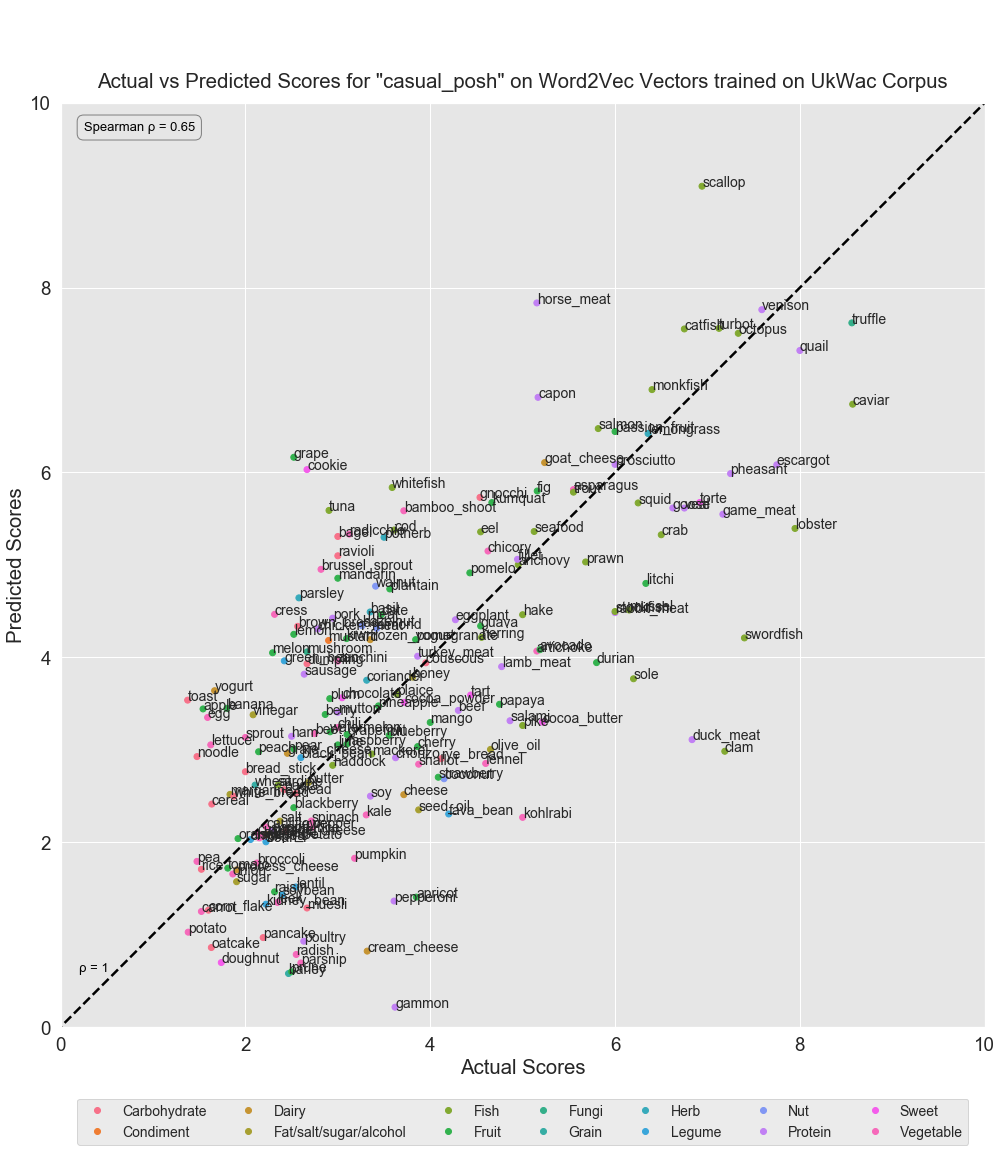

In [370]:
# Setup Seaborn plotstyle

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("notebook", font_scale=1.7,
                rc={"lines.linewidth": 2.5})

plt.figure(figsize=(30, 17))

# Choose color palette with seaborn 
num_classes = len(np.unique(annotations))
palette = np.array(sns.color_palette("husl", num_classes))

# Create labels and annotations and zip with palette
annos = list(zip(palette, sorted(list(set(annotations)))))

# Create scatter plot for points
ax = plt.subplot(aspect='equal')
ax.scatter(y, cv_pred, c=palette[map_annotations(annotations).astype(np.int)])

plt.gca()
plt.text(0.25, 9.7, 'Spearman ρ = ' + str(round(rho, 3)), color='black', bbox=dict(facecolor='none', edgecolor='gray', 
        boxstyle='round, pad=.5'), fontsize=13)

# Create regression plot for line
plt.plot([-1,100], [-1,100], c='black', linestyle='--')
plt.annotate('ρ = 1', xy=(0.20, 0.60), color='black', fontsize=13)

#Creat second legend for colormapped points
for i, anno in enumerate(annos):
    plt.plot([], [], ' ', c = palette[i], marker = 'o', label=str(anno[1]).capitalize())
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), fontsize=14, frameon = 1, ncol=7)

plt.title('Actual vs Predicted Scores for "casual_posh" on Word2Vec Vectors trained on UkWac Corpus', y=1.01)
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')

plt.xlim([0, 10])
plt.ylim([0, 10])
    
# Annotate points by norm
for i, txt in enumerate(norms):
    plt.annotate(txt, (y[i], cv_pred[i]), fontsize=14)

In [ ]:
# Advanced linear regression for advanced statistical parameters 

import statsmodels.api as sm

x = sm.add_constant(x)

In [ ]:
predictions = []
y_test_lst = []

kf = KFold(n_splits=10)
kf.get_n_splits(x)

for k, (train_index, test_index) in enumerate(kf.split(x, y)):
    x_train, x_test, y_train, y_test = x[train_index], x[test_index], y[train_index], y[test_index]

In [ ]:
# Create advanced model and fit

model = sm.OLS(y_train, x_train)

In [ ]:
# Fit results

results = model.fit()

In [ ]:
# Extract evaluation metrics

#print(results.summary())
#print('coefficient of determination r_2:', results.rsquared)
print('adjusted coefficient of determination adj r_2:', results.rsquared_adj)

In [ ]:
rho, pval = spearmanr(y, cv_pred)

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plt.figure(figsize=(16, 12))

points = plt.scatter(y, cv_pred, c=y, cmap='Blues')#(x, y)
plt.colorbar(points)
sns.regplot(y, cv_pred, scatter=False)
plt.title('Predicted Scores for "local_foreign" on fastText Vectors in ukWac and Gigaword Corpus')
plt.xlabel('Predicted ukWac')
plt.ylabel('Predicted Gigaword')
plt.legend(['ukWac', 'Gigaword', 'Spearman ρ = ' + str(round(rho, 2))])
plt.xlim([1, 9])
plt.ylim([1, 9])
for i, txt in enumerate(norms):
    plt.annotate(txt, (y[i], cv_pred[i]))